In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Analyzing 600 records for Collared flycatcher...


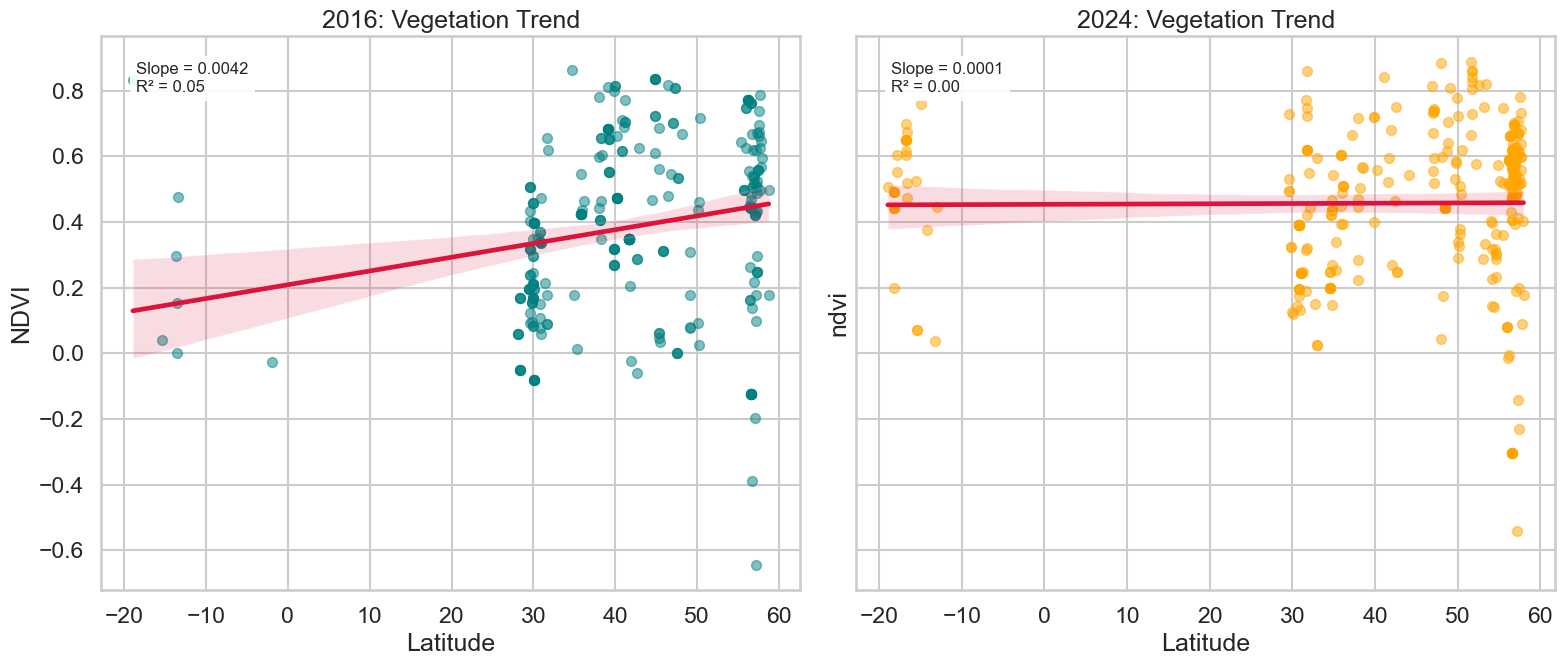

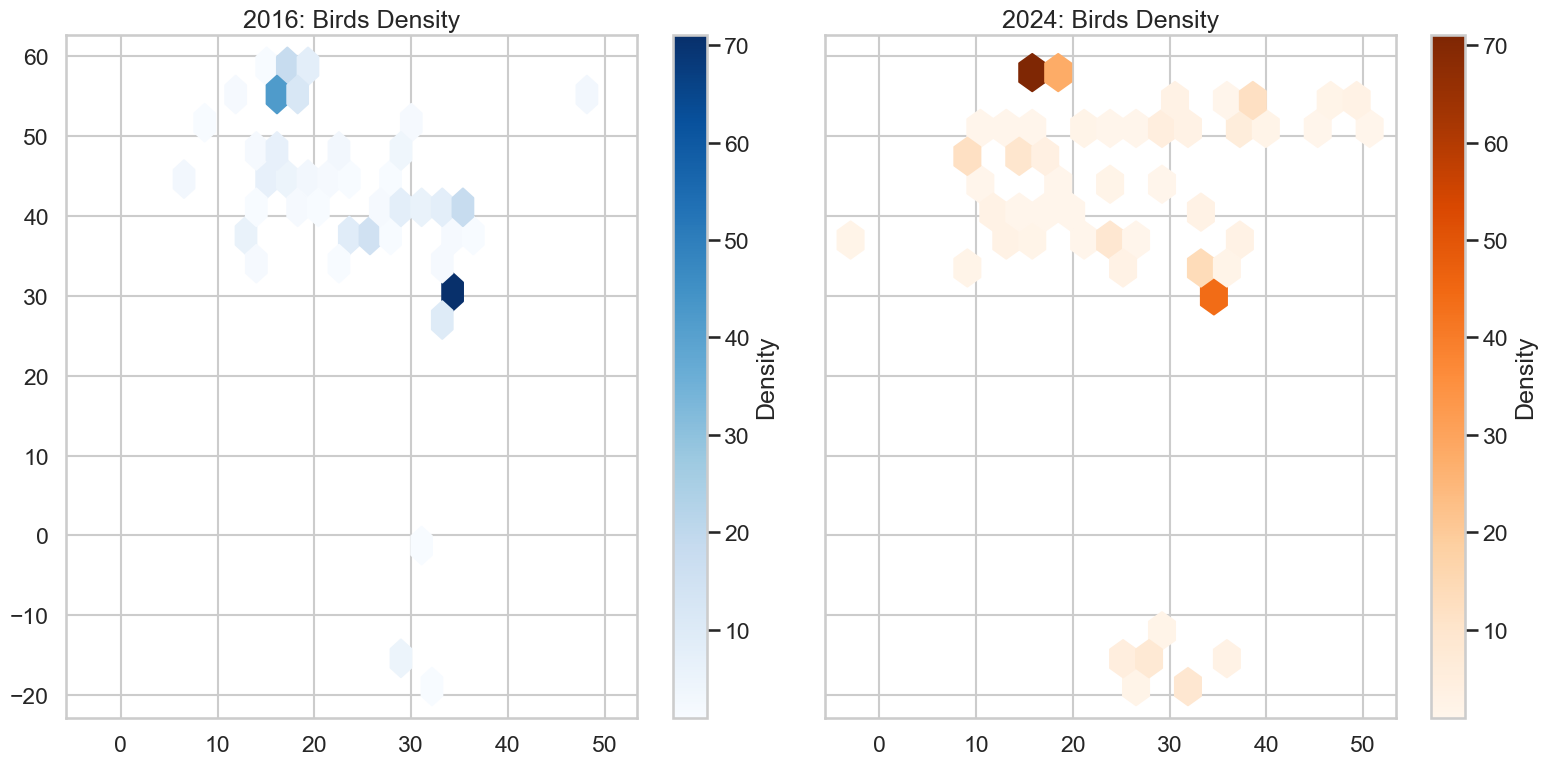

In [2]:
sns.set_theme(style="whitegrid", context="talk")
target_species = 'Collared flycatcher'
years_of_interest = [2016, 2024]

try:
    df_full = pd.read_csv('../Data/birds_db.csv')
    df_full.columns = df_full.columns.str.strip()

    df = df_full[
        (df_full['species'] == target_species) &
        (df_full['year'].isin(years_of_interest))
    ].copy()

    print(f"Analyzing {len(df)} records for {target_species}...")

    if not df.empty:
        fig1, axes1 = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

        for i, year in enumerate(years_of_interest):
            ax = axes1[i]
            data = df[df['year'] == year]

            if not data.empty:
                sns.regplot(data=data, x='latitude', y='ndvi', ax=ax,
                            scatter_kws={'alpha':0.5, 's': 50, 'color': 'teal' if year==2016 else 'orange'},
                            line_kws={'color': 'crimson'})

                slope, intercept, r_val, p_val, std_err = stats.linregress(data['latitude'], data['ndvi'])
                ax.text(0.05, 0.9, f"Slope = {slope:.4f}\nR² = {r_val**2:.2f}",
                        transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.9))

                ax.set_title(f"{year}: Vegetation Trend")
                ax.set_xlabel("Latitude")
                if i==0: ax.set_ylabel("NDVI")

        plt.tight_layout()
        plt.savefig('Results/Vegetation Trend.png')
        plt.show()

        fig2, axes2 = plt.subplots(1, 2, figsize=(16, 8), sharey=True, sharex=True)

        for i, year in enumerate(years_of_interest):
            ax = axes2[i]
            data = df[df['year'] == year]

            if not data.empty:
                hb = ax.hexbin(data['longitude'], data['latitude'], gridsize=20,
                               cmap='Blues' if year==2016 else 'Oranges', mincnt=1)

                hb_ndvi = ax.hexbin(data['longitude'], data['latitude'], C=data['ndvi'],
                                    gridsize=20, reduce_C_function=np.mean, visible=False)

                max_idx = np.argmax(hb_ndvi.get_array())
                best_loc = hb_ndvi.get_offsets()[max_idx]
                ax.set_title(f"{year}: Birds Density")
                plt.colorbar(hb, ax=ax, label='Density')

        plt.tight_layout()
        plt.savefig('Results/Birds Density.png')
        plt.show()

except FileNotFoundError:
    print("Error: birds_db.csv not found.")

In [3]:
print("\n--- TOP 2 LOCATIONS (Highest NDVI) ---")
for year in [2016, 2024]:
    year_data = df[df['year'] == year]
    # Get top 2 rows sorted by NDVI
    top_2 = year_data.nlargest(2, 'ndvi')[['latitude', 'longitude', 'ndvi', 'country']]
    print(f"\nYear {year}:")
    print(top_2.to_string(index=False))


--- TOP 2 LOCATIONS (Highest NDVI) ---

Year 2016:
 latitude  longitude     ndvi country
34.768900  32.557400 0.864579  Cyprus
44.870045  15.600672 0.834624 Croatia

Year 2024:
 latitude  longitude     ndvi            country
51.603350  39.118430 0.889088 Russian Federation
48.010016  16.169052 0.884078            Austria


In [4]:
df['lat_bin'] = df['latitude'].round(1)
df['lon_bin'] = df['longitude'].round(1)

grid_stats = df.groupby(['lat_bin', 'lon_bin', 'year'])['ndvi'].mean().unstack()

common_bins = grid_stats.dropna().copy()
common_bins['change'] = common_bins[2024] - common_bins[2016]

print("Biggest Drop (Worse Habitat):")
print(common_bins.sort_values('change').head(2))

print("\nBiggest Gain (Better Habitat):")
print(common_bins.sort_values('change', ascending=False).head(2))

Biggest Drop (Worse Habitat):
year                2016      2024    change
lat_bin lon_bin                             
56.0    15.8     0.74759  0.081776 -0.665814
57.7    18.4     0.64213  0.089060 -0.553070

Biggest Gain (Better Habitat):
year                 2016      2024    change
lat_bin lon_bin                              
56.7    16.5    -0.389886  0.580801  0.970687
57.2    17.0    -0.644444 -0.027186  0.617258
